# Tutorial on how to use __sbk__

#### We present here the different current functionalities of __sbk__ and how to use it.
* Import everything that is needed, and define generic variables
* Look at [requirements.txt](../requirements.txt) for all required dependencies

## Table of contents
1. Compute number of batches
2. Compute __bk__ days
3. Building storylines
    1. The Swedish storyline
---

## Simplified flowchart of `sbk` structure
<img src="data/sbk_structure.png" alt="sbk simplified structure" width="600"/>

Typically, number of batches (`Batches` class) is computed from DNI (as a instance inherited from the `GridDB` mother class) and oven behavior based on some `OvenModel` instantiation or bakery behavior, based on `Oven` and `OrganizationModel`. Organization is built upon `Scenario` that gather both schedule and strategy. Bakeable periods are then derived from the number of batches.

---
## 1. Compute number of batches

Here is an example of the computation of _bakeable_ days or _bk_ days, where bread might be baked. We get 2020 DNI data from the [__CMSAF__](https://wui.cmsaf.eu/safira/action/viewHome) operation center (Satellite Application Facility on Climate Monitoring) under netcdf format.

In [1]:
import os
import sys
sys.path.append("../")

from sbk.grid_db.sarah import Sarah3
from sbk.analysis.descriptors import Batches, Bakable
from sbk.bakery import WeekOrganizationModel, Bakery
from sbk.bakery.oven import Oven
from sbk.bakery.models import SolarThresholdModel

in_dir = '/tmp/data/' + 'SWEDEN_JUNE_2020'
out_dir = "data"
nc_batches = os.path.join(out_dir, "nb_batches.nc")
raster_batches = os.path.join(out_dir, "nb_batches.tif")
nc_bk = os.path.join(out_dir, "bk_days.nc")
raster_bk = os.path.join(out_dir, "nb_bk_days.tif")

#### Use a test dataset of DNI data and extract to `tmp` directory
* Here we use some days in June 2020 over Sweden (see [SWEDEN_JUNE_2020](data/)). To get a more complete example, i.e. over the whole 2020 year, change to [SWEDEN_2020](data/)

In [2]:
import tarfile

archive = 'data/SWEDEN_JUNE_2020.tar.xz'
temp_dir = '/tmp/data'
file = tarfile.open(archive)
file.extractall(temp_dir)

#### Build DNI from netcdf files in directory
* Build DNI as `Sarah3` class instance from multiple netcdf files in directory

In [3]:
dni = Sarah3.build_from_dir(in_dir, "DNI")

#### Build `Oven` class instance based on the `SolarThresholdModel` model
* `Oven` class defines the oven's behavior based on the selected model
* `SolarThresholdModel` class is the simplest implemented model, based on empirical thresholds derived from [NeoLoco](https://neoloco.fr/) feedback. This class inherits from the `OvenModel` base class

In [4]:
oven = Oven(SolarThresholdModel(700, 2, 1))

#### Build `Bakery` class model composed of `Oven` and `OrganizationModel`
* The oven is the technical model based on exogenous variables (DNI, temperature, etc.) and endogenous parameters (system behavior)
* `OrganizationModel` is about the social counterpart in the bakery's behavior. It considers both schedule and strategy regarding multiscalar organization: for a week scenario, schedule records hour ranges of all working days, and strategy is about how the baker wants to use those working days : best one among all, best 2 among all, all, etc. See the example below for `WeekOrganizationModel`:


In [10]:
# Working days here are defined as monday to wednesday
# Hourly ranges are defined as tuples in the brackets
working_days = dict(monday=[(7,12)],
                    tuesday=[(7,12), (14,18)],
                    wednesday=[(7,12),(14,18)])
# Strategy
nb_days = 2  # take the 2 best days among the 3 candidates in the week
max_batches = 4  # Consider that max nb of batches is 4 per day

orga = WeekOrganizationModel(working_days, nb_days, max_output=max_batches)

* Implementing no schedule and no strategy is possible through the `default_model` class method

In [11]:
default_orga = WeekOrganizationModel.default_model()

* You can switch between `orga` and `default_orga`

In [12]:
# Switch between orga and default_orga
bakery = Bakery(oven=oven, organization_model=orga)

#### Build netcdf file for given descriptor (Batches)
* Build class instance `Batches`
* Compute batches from DNI
* Resample data according to the `rule` and `resampler` (here, we sum data over each day)
* Save data to netcdf file

In [13]:
batches= Batches(bakery)
batches.compute(dni)

In [14]:
batches.resample(rule="D", resampler="sum")
batches.save(nc_batches)

#### Build raster for given descriptor (Batches) from netcdf file
* Build `Sarah3` instance from netcdf file
* Perform monthly resampling
* Convert to raster
* Save to `raster_file` file (that you may open with appplication such as [QGIS](https://www.qgis.org/)) 

In [9]:
nb_batches = Sarah3.build_from_dir(nc_batches, Batches.name)
nb_batches = nb_batches.resample("M", "sum")
raster = nb_batches.to_raster()
raster.to_file(raster_batches)

0

---
## 2. Compute number of __bk__ days
Now we may retrieve __bk days__ or _bakeable days_ which are days that we consider __OK__ for baking bread. __bk__ days are derived from the number of batches.
* Retrieve nb of batches from netcdf file, as a `Sarah3` class instance
* Compute __bk days__ with respect to batches and `threshold` which corresponds to the minimum nb of batches for a period to be considered _bakeable_
* Save data to netcdf file

In [14]:
nb_batches = Sarah3.build_from_dir(nc_batches, Batches.name)
bk_days = Bakable().compute(nb_batches, threshold=1)
bk_days.save(nc_bk)

#### Build raster of __bk__ days

In [15]:
bk_days = Sarah3.build_from_dir(nc_bk, Bakable.name)
bk_days = bk_days.resample("Y", "sum")
raster = bk_days.to_raster()
raster.to_file(raster_bk)

0

---
## 3. Building storylines
### A. The Swedish storyline for solar baking <a class="anchor" id="section3"></a>

Here, we depict how we may apply __sbk__ to generate scenarios for a specific location. We look at possible storylines in Sweden regarding hybrid supply for baking bread, with respect to the social and cultural factors in the country.

In [2]:
import plotly.express as px
import numpy as np
import pandas as pd
import sys
sys.path.append("../")
from sbk.analysis.default_samples import _truncnorm

sample_size = 10000

#### Bread consumption in Sweden :
Bread consumption has been depicted in the study by [Sandvik et al., 2014](https://foodandnutritionresearch.net/index.php/fnr/article/view/664), from which we have adapted the following distributions.
* Consumption of bread (g/week) :

In [3]:
swedish_consumption_of_bread = _truncnorm(0.472, 0.26, [0.05, np.inf])
swedish_consumption_of_bread_pdf = swedish_consumption_of_bread.rvs(size=sample_size)

* Consumption of whole-grain bread (g/week):

In [4]:
swedish_whole_grain_cons = _truncnorm(526/1435, 50/1435, [0, 1])
swedish_whole_grain_cons_pdf = swedish_whole_grain_cons.rvs(size=sample_size)

* Probability of consuming bread in Sweden:

In [5]:
swedish_bread_consumer = _truncnorm(0.98, 0.02, [0, 1])
swedish_bread_consumer_pdf = swedish_bread_consumer.rvs(size=sample_size)

##### Build a DataFrame

In [6]:
df = pd.DataFrame.from_dict({"Consumption of bread": 1000 * swedish_consumption_of_bread_pdf,
                             "Consumption of whole-grain bread": 1000 * swedish_whole_grain_cons_pdf,
                             "Probability of being a bread consumer" : swedish_bread_consumer_pdf})

##### Plot consumption

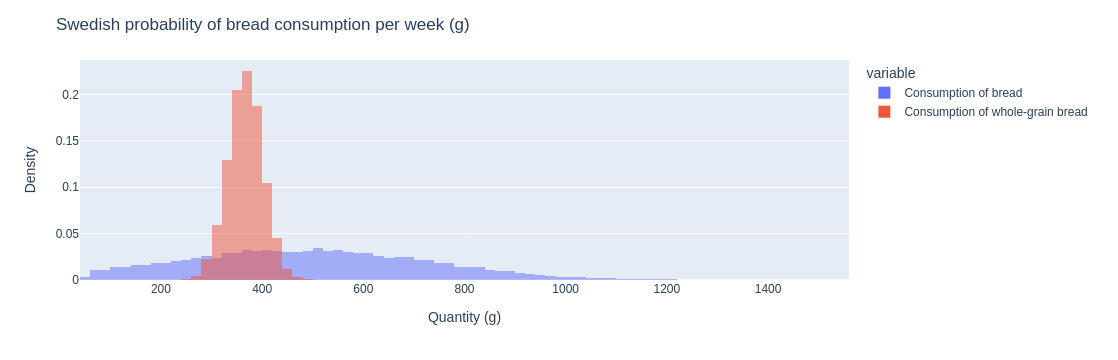

In [12]:
fig = px.histogram(df.loc[:, [True, True, False]], nbins=100, 
                   histnorm="probability", barmode="overlay")
fig.update_layout(
    title="Swedish probability of bread consumption per week (g)",
    xaxis_title="Quantity (g)",
    yaxis_title="Density")

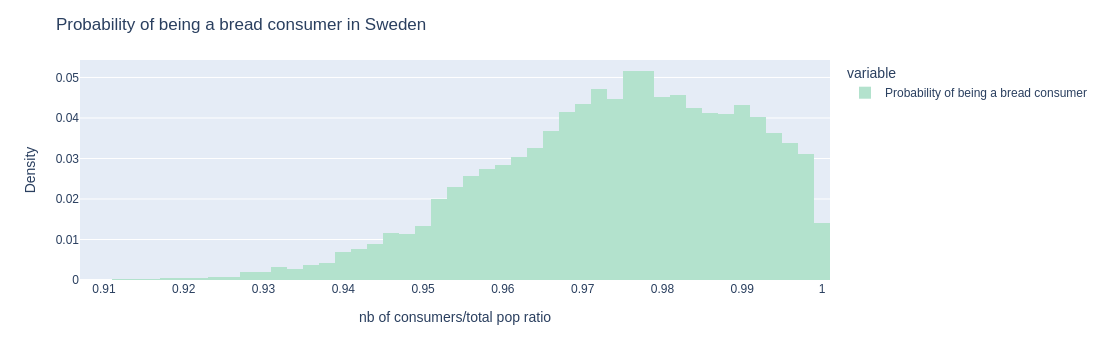

In [11]:
fig2 = px.histogram(df.loc[:, "Probability of being a bread consumer"], 
                    nbins=80, 
                    histnorm="probability", 
                    color_discrete_sequence=px.colors.qualitative.Pastel2)
fig2.update_layout(
    title="Probability of being a bread consumer in Sweden",
    xaxis_title="nb of consumers/total pop ratio",
    yaxis_title="Density")